In [20]:
import scanpy as sc
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import os
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix



from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import entropy

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:

def downsample_and_predict(reflatent_seurat,label ,scANVI, subsample_size,min_cell):
    cell_ranks = reflatent_seurat.obs[label].cat.categories
    downsampled_cells = []

    for cell_rank in cell_ranks:
        current_cells = np.where(reflatent_seurat.obs[label] == cell_rank)[0]
        if min(len(current_cells), subsample_size) < subsample_size:
            print(f"The current ident {cell_rank} is smaller than the sample size, adjust to the ident size")
        if len(current_cells) > min_cell:
            downsampled_cells.extend(np.random.choice(current_cells, size=min(len(current_cells), subsample_size), replace=False))
        else:
            print(f"The current ident {cell_rank} is too small, skipping")

    downsample_seurat = reflatent_seurat[downsampled_cells,: ]

    # Prepare data for RandomForest
    X = downsample_seurat.obsm[scANVI]
    y = LabelEncoder().fit_transform(downsample_seurat.obs[label])

    # Train a RandomForest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X, y)

    # Get the class probabilities
    class_probs = rf_model.predict_proba(X)
    class_labels = rf_model.classes_

    # Create a DataFrame from the class probabilities
    votes = pd.DataFrame(data=class_probs, columns=class_labels)
    votes['ident'] = downsample_seurat.obs[label].values

    # Calculate class probabilities per cluster
    summary = votes.groupby('ident').mean()

    # Normalize the summary matrix
    summary = summary.divide(summary.max(axis=1), axis=0).fillna(0)
    np.fill_diagonal(summary.values, 0)
    summary.columns=summary.index.values


    return summary


In [14]:
import sys
sys.path.append("../../function/")
import HCLA_utils
import HCLA_analyze

In [4]:
adata=sc.read("../../important_processed_data/5.22_integrate_adata.h5ad")

In [7]:
age_grades = [ 'Organogenesis stage','Fetal stage',  'Postnatal', 'Young Adult','Adult', 'Old']
age_detail_grade=["E9", "E10", "5 WPC",   "E11", "E11.5", "E12", "E12.5", "E13",
                  "E13.5", "E14", "E14.5", "E15", "E15.5", "E16", "14 WPC", 
                  "E16.5", "E17", "E17.5", "16 WPC", "17 WPC","E18", "19 WPC","E18.5",
                  "P2", "P3", "P4-P5", "P5", "P6", "P7", 
                  "P7.5", "P10", "P11", "P13", "P14", "P18","3W",
                  "P19", "P21", "P23", "P25","4W", "P28","1M",  "5W", "P42","1.5M",  
                  "P56", "6W", "7W", "8W","2M","10W","8-12W",  "9-12W", 
                  "10-12W",  "11W", "11-12W", "12W",
                  "10-14W","2-4M", "3M", "14W", 
                  "4M", "Adult","12M", "12-14M", 
                  "15 WPC", "16M",  "18M" ]
# 创建一个空的映射字典
age_grades_mapping = {}

# 使用enumerate函数创建映射
for i, grade in enumerate(age_grades, start=1):
    age_grades_mapping[grade] = i

age_grades_detail_mapping = {}

# 使用enumerate函数创建映射
for i, grade in enumerate(age_detail_grade, start=1):
    age_grades_detail_mapping[grade] = i

adata.obs['Age_num'] = adata.obs['Age'].map(age_grades_mapping).values
adata.obs['Age_detail_num'] = adata.obs['Age.In.Detail.'].map(age_grades_detail_mapping).values

In [254]:
adata_ob=adata[adata.obs["C7_named"]=="Ob",:]

In [255]:
adata

AnnData object with n_obs × n_vars = 272369 × 18322
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'le

In [256]:
obDF=downsample_and_predict(adata_ob,"Project" ,"X_scANVI",subsample_size=1000)

The current ident Ablation_Matsushita is smaller than the sample size, adjust to the ident size
The current ident Bmsc2019_Regev is smaller than the sample size, adjust to the ident size
The current ident BmscChondro_Long is smaller than the sample size, adjust to the ident size
The current ident CalvariaP4_Ayturk is smaller than the sample size, adjust to the ident size
The current ident ChondroOsteo_Long is smaller than the sample size, adjust to the ident size
The current ident CranioSoxc_Angelozzi is smaller than the sample size, adjust to the ident size
The current ident Forelimb_He is smaller than the sample size, adjust to the ident size
The current ident Frontal_Holmes is smaller than the sample size, adjust to the ident size
The current ident GrowthplateSox9_Abdul is smaller than the sample size, adjust to the ident size
The current ident LimbG610C_Gorrell is smaller than the sample size, adjust to the ident size
The current ident LimbMouse2019_Kelly is smaller than the sample

In [265]:
ncol=len(obDF.index)-1

In [266]:
obDF.sum().sum()/(ncol*ncol)

0.017640307694124814

In [267]:
adata.obs["C7_named"]

Unnamed: 0
Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0           MSC
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0     Ly6a+ MSC
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0            Ob
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0            Ob
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0    Lepr+ BMSC
                                                   ...    
TTTGACTGTATTTCCT-1_5-1-2                               MSC
TTTGACTGTTGCATTG-1_5-1-2                               MSC
TTTGACTTCTTGGGCG-1_5-1-2                           Chondro
TTTGGAGCAGCGACAA-1_5-1-2                                Ob
TTTGGTTCACTACTTT-1_5-1-2                                Ob
Name: C7_named, Length: 272369, dtype: category
Categories (7, object): ['Chondro', 'Fibroblast', 'Lepr+ BMSC', 'Ly6a+ MSC', 'MSC', 'Ob', 'Pericyte']

In [268]:
adata_chondro=adata[adata.obs["C7_named"]=="Chondro",:]

In [269]:
chondroDF=downsample_and_predict(adata_chondro,"Project" ,"X_scANVI",subsample_size=1000)

The current ident Ablation_Matsushita is smaller than the sample size, adjust to the ident size
The current ident BmscChondro_Long is smaller than the sample size, adjust to the ident size
The current ident CalvariaP4_Ayturk is smaller than the sample size, adjust to the ident size
The current ident Forelimb_He is smaller than the sample size, adjust to the ident size
The current ident Frontal_Holmes is smaller than the sample size, adjust to the ident size
The current ident LimbG610C_Gorrell is smaller than the sample size, adjust to the ident size
The current ident Mandible2020_Chai is smaller than the sample size, adjust to the ident size
The current ident Maxillary_Bian is smaller than the sample size, adjust to the ident size
The current ident Mesenchymal2022_Zhang is smaller than the sample size, adjust to the ident size
The current ident PerichondrialP21_Matsushita is smaller than the sample size, adjust to the ident size
The current ident Suture2021_Farmer is smaller than the s

In [270]:
ncol=len(chondroDF.index)-1
chondroDF.sum().sum()/(ncol*ncol)

0.013560373971026477

In [273]:
adata_lepr=adata[adata.obs["C7_named"]=="Lepr+ BMSC",:]
leprDF=downsample_and_predict(adata_lepr,"Project" ,"X_scANVI",subsample_size=1000)
ncol=len(leprDF.index)-1
leprDF.sum().sum()/(ncol*ncol)

The current ident BmscChondro_Long is smaller than the sample size, adjust to the ident size
The current ident CalvariaP4_Ayturk is smaller than the sample size, adjust to the ident size
The current ident ChondroOsteo_Long is smaller than the sample size, adjust to the ident size
The current ident Forelimb_He is smaller than the sample size, adjust to the ident size
The current ident Frontal_Holmes is smaller than the sample size, adjust to the ident size
The current ident LimbG610C_Gorrell is smaller than the sample size, adjust to the ident size
The current ident LimbMouse2019_Kelly is smaller than the sample size, adjust to the ident size
The current ident Mandible2020_Chai is smaller than the sample size, adjust to the ident size
The current ident Maxillary_Bian is smaller than the sample size, adjust to the ident size
The current ident Mesenchymal2022_Zhang is smaller than the sample size, adjust to the ident size
The current ident Metaphysis_Yang is smaller than the sample size, 

0.019267137503168958

In [274]:
cellType

['MSC', 'Ob', 'Lepr+ BMSC', 'Pericyte', 'Fibroblast', 'Chondro', 'Ly6a+ MSC']

In [288]:
cellSimilar=[]
cellNum=[]
for i in cellType:
    adata_sub=adata[adata.obs["C7_named"]==i,:]
    celltypeDF=downsample_and_predict(adata_sub,"Project" ,"X_scANVI",subsample_size=1000,min_cell=50)
    ncol=len(celltypeDF.index)-1
    cellSimilar.append(celltypeDF.sum().sum()/(ncol*ncol))
    cellNum.append(ncol+1)

The current ident BmscChondro_Long is smaller than the sample size, adjust to the ident size
The current ident BmscChondro_Long is too small, skipping
The current ident ChondroOsteo_Long is smaller than the sample size, adjust to the ident size
The current ident GrowthPlateP0_Mizuhashi is smaller than the sample size, adjust to the ident size
The current ident GrowthPlateP0_Mizuhashi is too small, skipping
The current ident GrowthplateSox9_Abdul is smaller than the sample size, adjust to the ident size
The current ident Ablation_Matsushita is smaller than the sample size, adjust to the ident size
The current ident Bmsc2019_Regev is smaller than the sample size, adjust to the ident size
The current ident BmscChondro_Long is smaller than the sample size, adjust to the ident size
The current ident BmscChondro_Long is too small, skipping
The current ident CalvariaP4_Ayturk is smaller than the sample size, adjust to the ident size
The current ident ChondroOsteo_Long is smaller than the samp

In [289]:
cellSimilar

[0.01673662235030726,
 0.02028238342230487,
 0.024369328499180012,
 0.0312517281270297,
 0.029119417121434357,
 0.016819235118494383,
 0.024698565212546562]

In [291]:
cellNum

[24, 19, 17, 10, 12, 20, 16]

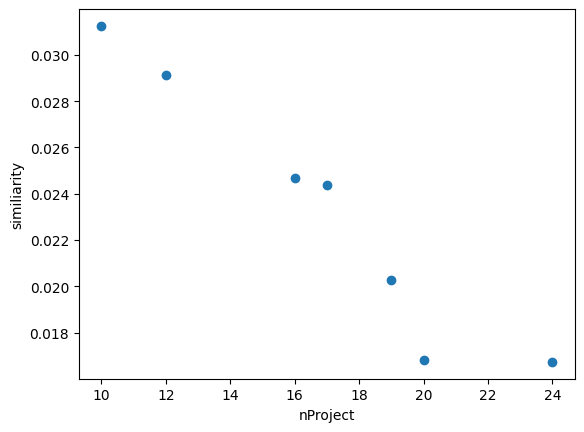

In [294]:
plt.scatter( cellNum,cellSimilar)
plt.xlabel("nProject")
plt.ylabel("similiarity")
plt.show()

In [308]:
celltype=['CPC',
 'Col1a1.Chondro',
 'Cyp26a1.Chondro',
 'Early.MSC',
 'Fibro',
 'HC',
 'Hmmr+ CPC',
 'Irx1+ MSC',
 'Late.MSC',
 'Lepr+ BMSC',
 'Ly6a+ MSC',
 'Mature Chondro',
 'Meninges',
 'Middle.MSC',
 'Ob',
 'Pericyte',
 'Pre-ob']

In [309]:
cellSimilarC19=[]
cellNumC19=[]
for i in celltype:
    adata_sub=adata[adata.obs["C19_named"]==i,:]
    celltypeDF=downsample_and_predict(adata_sub,"Project" ,"X_scANVI",subsample_size=1000,min_cell=50)
    ncol=len(celltypeDF.index)-1
    cellSimilarC19.append(celltypeDF.sum().sum()/(ncol*ncol))
    cellNumC19.append(ncol+1)

The current ident Ablation_Matsushita is smaller than the sample size, adjust to the ident size
The current ident Ablation_Matsushita is too small, skipping
The current ident BmscEndosteal_Ono is smaller than the sample size, adjust to the ident size
The current ident BmscTime_Zhong is smaller than the sample size, adjust to the ident size
The current ident CalvariaP4_Ayturk is smaller than the sample size, adjust to the ident size
The current ident ChondroOsteo_Long is smaller than the sample size, adjust to the ident size
The current ident ChondroOsteo_Long is too small, skipping
The current ident Forelimb_He is smaller than the sample size, adjust to the ident size
The current ident Frontal_Holmes is smaller than the sample size, adjust to the ident size
The current ident Frontal_Holmes is too small, skipping
The current ident LimbG610C_Gorrell is smaller than the sample size, adjust to the ident size
The current ident Mandible2020_Chai is smaller than the sample size, adjust to the

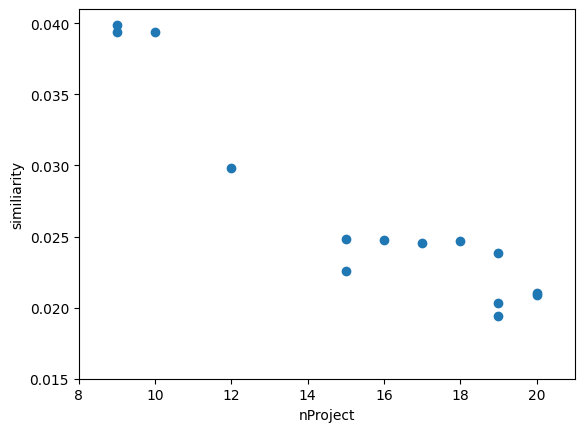

In [322]:
plt.scatter( cellNumC19,cellSimilarC19)
plt.xlabel("nProject")
plt.ylabel("similiarity")
plt.ylim(0.015,0.041)
plt.xlim(8,21)
plt.show()

In [311]:
cellSimilarC19

[0.01943989045111824,
 nan,
 nan,
 0.023873078148274128,
 0.029827768943927444,
 0.0394161130363129,
 0.02482764809589958,
 0.03987232427579962,
 0.02089708750714865,
 0.024545125634843467,
 0.024728365528450237,
 0.022553956137371194,
 0.11355624385219484,
 0.024687101729142097,
 0.020345803933395277,
 0.039406336836922566,
 0.021045461596134605]

In [10]:
def add_cell_annotations(adata, var_index):
    """ This function adds annotation to anndata:  
    cell level:  
    total_counts, log10_total_counts, n_genes_detected, mito_frac, ribo_frac,   
    compl(exity)  
    gene_level:  
    n_cells 

    Arguments:
        adata - anndata object, raw (unnormalized!)
        var_index < "gene_symbols", "gene_ids" > - set to which type of gene
            naming is used in adata.var.index

    Returns:
        anndata object with annotations  
    """
    # cells:
    # total transcript count per cell
    adata.obs['total_counts'] = np.sum(adata.layers['counts'], axis=1)
    adata.obs['log10_total_counts'] = np.log10(adata.obs['total_counts'])
    # number of genes expressed
    # translate matrix to boolean (True if count is larger than 0):
    boolean_expression = adata.X > 0
    adata.obs['n_genes_detected'] = np.sum(boolean_expression, axis=1)
    # fraction mitochondrial transcripts per cell
    if var_index == "gene_symbols":
        mito_genes = [
            gene for gene in adata.var.index if gene.lower().startswith("mt-")
        ]
    elif var_index == "gene_ids":
        mito_genes = [
            gene_id
            for gene_id, gene_symbol in zip(adata.var.index, adata.var.gene_symbols)
            if gene_symbol.lower().startswith("mt-")
        ]
    else:
        raise ValueError(
            "var_index argument should be set to either gene_symbols or gene_ids"
        )
    # conversion to array in line below is necessary if adata.X is sparse
    adata.obs['mito_frac'] = np.array(np.sum(
        adata[:,mito_genes].X, axis=1)).flatten() / adata.obs['total_counts']
    # fraction ribosomal transcripts per cell
    if var_index == "gene_symbols":
        ribo_genes = [
            gene
            for gene in adata.var.index
            if (gene.lower().startswith("rpl") or gene.lower().startswith("rps"))
        ]
    elif var_index == "gene_ids":
        ribo_genes = [
            gene_id
            for gene_id, gene_symbol in zip(adata.var.index, adata.var.gene_symbols)
            if (
                gene_symbol.lower().startswith("rpl")
                or gene_symbol.lower().startswith("rps")
            )
        ]
    adata.obs['ribo_frac'] = np.array(np.sum(
        adata[:,ribo_genes].X, axis=1)).flatten() / adata.obs['total_counts']
    # cell complexity (i.e. number of genes detected / total transcripts)
    adata.obs['compl'] = adata.obs['n_genes_detected']\
    / adata.obs['total_counts']
    # genes
    adata.var['n_cells'] = np.sum(boolean_expression, axis=0).T
    return adata

In [11]:
adata=add_cell_annotations(adata,"gene_symbols")

In [349]:
num_bins = 10
_, bin_edges = np.histogram(adata.obs["log10_total_counts"], bins=num_bins)
bin_test=np.digitize(adata.obs["log10_total_counts"], bin_edges)

In [390]:
def num_to_bin(num,num_bins=10):
    num_bins = 10
    _, bin_edges = np.histogram(adata.obs[num], bins=num_bins)
    new_bin=np.digitize(adata.obs[num], bin_edges)
    num_add=num+"_bin"
    adata.obs[num_add]=new_bin
    adata.obs[num_add]=adata.obs[num_add].astype("category")

In [391]:
num_to_bin("log10_total_counts")
num_to_bin("n_genes_detected")
num_to_bin("mito_frac")
num_to_bin("ribo_frac")
num_to_bin('compl')

In [392]:
adata.obs["compl_bin"].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ordered=False)

In [323]:
cellNumC19

[19, 1, 1, 19, 12, 10, 15, 9, 20, 17, 16, 15, 4, 18, 19, 9, 20]

In [407]:
cov=["Project","Sample",'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 
     'Treatment', 'Age', 'Age.In.Detail.',
     'log10_total_counts_bin', 'n_genes_detected_bin', 'mito_frac_bin', 'ribo_frac_bin', 'compl_bin']

In [363]:
celltype=list(set(adata.obs["C7_named"]))

In [369]:
similarDf=pd.DataFrame(index=cov,columns=celltype)

In [394]:
similarDf

,MSC,Ob,Lepr+ BMSC,Pericyte,Fibroblast,Chondro,Ly6a+ MSC
Organ,0.118881,0.131242,0.145857,0.08857,0.102262,0.114186,0.090329
Tissue,0.03703,0.053949,0.056704,0.042223,0.050803,0.029072,0.051974
Tissue.Specific.,0.023378,0.02884,0.031255,0.052178,0.034306,0.0204,0.030635
Stage,0.118965,0.14508,0.177669,0.161049,0.091971,0.138412,0.095561
Gene.type,0.126431,0.16107,0.16963,0.158877,0.251009,0.099376,0.253042
Treatment,0.090564,0.096597,0.095487,0.220903,0.096077,0.062829,0.134388
Age,0.061879,0.076653,0.066013,0.055207,0.058271,0.054435,0.069149
Age.In.Detail.,0.037869,0.039911,0.035783,0.066504,0.065255,0.028168,0.045275
log10_total_counts_bin,0.055266,0.06415,0.064161,0.062563,0.069658,0.048459,0.075079
n_genes_detected_bin,0.052666,0.064131,0.076792,0.079433,0.091033,0.055125,0.087829


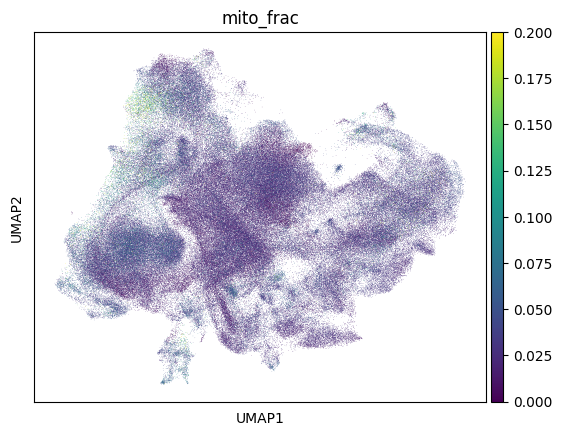

In [397]:
sc.pl.umap(adata,color="mito_frac",vmax=0.2)

In [393]:
for i in celltype:
    adata_sub=adata[adata.obs["C7_named"]==i,:]
    for j in cov:
        celltypeDF=downsample_and_predict(adata_sub,j ,"X_scANVI",subsample_size=1000,min_cell=25)
        ncol=len(celltypeDF.index)-1
        cellSimilar= celltypeDF.sum().sum()/(ncol*ncol)
        similarDf.loc[j,i]=cellSimilar


The current ident Distal femur;Proximal tibial  is smaller than the sample size, adjust to the ident size
The current ident Femur;Tibia;Fibula is smaller than the sample size, adjust to the ident size
The current ident Bone is smaller than the sample size, adjust to the ident size
The current ident Epiphysis is smaller than the sample size, adjust to the ident size
The current ident Growth plate is smaller than the sample size, adjust to the ident size
The current ident Injury(Regeneration) is smaller than the sample size, adjust to the ident size
The current ident KO is smaller than the sample size, adjust to the ident size
The current ident Ablation(7 day) is smaller than the sample size, adjust to the ident size
The current ident Ablation(14 day) is smaller than the sample size, adjust to the ident size
The current ident Fgfr3Cre is smaller than the sample size, adjust to the ident size
The current ident Fgfr3Cre;Trp53(fl/+) is smaller than the sample size, adjust to the ident size


In [360]:
cellSimilarC19

[0.01943989045111824,
 nan,
 nan,
 0.023873078148274128,
 0.029827768943927444,
 0.0394161130363129,
 0.02482764809589958,
 0.03987232427579962,
 0.02089708750714865,
 0.024545125634843467,
 0.024728365528450237,
 0.022553956137371194,
 0.11355624385219484,
 0.024687101729142097,
 0.020345803933395277,
 0.039406336836922566,
 0.021045461596134605]

In [18]:
dir_results="../result/10.24_covariance/"

In [30]:
adata.obs["Age_num"]=adata.obs["Age_num"].astype("float")

In [28]:
adata

AnnData object with n_obs × n_vars = 272369 × 62934
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'le

In [31]:
int_types = ["integrated"]
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2
covariates=["Project","Sample",'Organ', 'Stage',
     'Treatment', 'Age_num', 'Age_detail_num',"Age","Origin",'Bone.Forming.Methods', 
            'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl']
outdir_1 = os.path.join(dir_results, f"variance_explained_fractions/")
if not os.path.exists(outdir_1):
    print("Creating directory:", outdir_1)
    os.makedirs(outdir_1)
outdir_2 = os.path.join(dir_results, f"samples_included/")
if not os.path.exists(outdir_2):
    print("Creating directory:", outdir_2)
    os.mkdir(outdir_2)
# Initiate a dictionary, in which we will store which samples were included per
# single regression
samples_included = dict()
cts_to_skip = list()  # we will fill this with cts that have too few samples
# these samples should be skipped in the rest of the analysis.
# Loop through specified integration types:
for int_type in int_types:
    samples_included[int_type] = dict()
    # loop through all annotations (= cell types), and also include the entire
    # atlas as a "cell type":
    for subset in sorted(adata.obs.C7_named.unique()) + ["whole_atlas"]:
        # remove space from cell type name, for file storing etc.
        subset_no_space = subset.replace(" ", "_")
        # initiate a dataframe, in which we will store for every covariate
        # which samples we include in the regression (we will exclude samples
        # that have no value available for the covariate under consideration
        # (e.g. BMI not recorded), as well as samples that have fewer than 10
        # cells of the cell type under consideration)
        samples_included[int_type][subset] = pd.DataFrame(
            index=adata.obs["Sample"].unique(), columns=covariates
        )
        # if file doesn't exist yet (built in this check for if loop breaks halfway,
        # feel free to take it out):
        if not os.path.isfile(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            )
        ):
            print(f"Working on {int_type}, {subset}...")
            # select the correct cells:
            if subset == "whole_atlas":
                subadata = adata.copy()
                verbose = True
            elif subset not in adata.obs.C7_named.unique():
                raise ValueError(
                    "subset should be set either to 'Whole atlas' or to a category in your manual_ann grouped obs variable!"
                )
            else:
                subadata = adata[adata.obs.C7_named == subset, :].copy()
                verbose = False
            if subadata.n_obs < min_n_cells_total:
                print(f"{subset} has fewer than {min_n_cells_total} cells! Skipping.")
                continue
            # select the right embedding:
            if int_type == "unintegrated":
                emb_name = "X_pca"
                sc.tl.pca(subadata, n_comps=n_pcs, use_highly_variable=True)
            elif int_type == "integrated":
                emb_name = "X_scANVI"
            else:
                raise ValueError(
                    "emb_name should be set either to 'integrated' or 'unintegrated'"
                )
            # store the number of components in our embedding of choice
            n_comps = subadata.obsm[emb_name].shape[1]
            # initiate a dataframe in which we'll store the variance explained
            # by each covariate, plus the total variance ("overall") observed
            var_explained = pd.DataFrame(
                index=range(n_comps), columns=covariates + ["overall"]
            )
            # initiate a dataframe in which we will store the data
            # for our linear regression (i.e. the PC/latent components, + covariates).
            # Rows are cells, but we will collapse this to samples below
            comp_sample_df = pd.DataFrame(index=subadata.obs.index)
            comp_sample_df["sample"] = subadata.obs["Sample"]
            # prepare aggregation dictionary for collapsing into sample-wise
            # observations
            agg_dict = {"sample": "count"}  # this will be number of cells
            for comp in range(n_comps):
                # store component scores per cell
                comp_sample_df[f"comp{comp}"] = subadata.obsm[emb_name][:, comp]
                # we will aggregate these later by taking the mean per sample
                agg_dict[f"comp{comp}"] = "mean"
            for cov in covariates:
                if cov in ['log10_total_counts', 'n_genes_detected','mito_frac','ribo_frac','compl']:
                    # store values
                    comp_sample_df[cov] = subadata.obs[cov]
                    # we will aggregate by taking the mean
                    agg_dict[cov] = "mean"
                else:
                    # for all other covariates: these are sample-level
                    # covariates, so we will take the "first" overservation
                    # in the sample (which should be the only)
                    comp_sample_df[cov] = subadata.obs[cov]
                    agg_dict[cov] = "first"
            # now collapse into sample-level observations
            sample_df = (
                comp_sample_df.groupby("sample")
                .agg(agg_dict)
                .rename(columns={"sample": "n_cells"})
            )
            # filter out samples with fewer than min_n_cells cells of the cell type
            sample_df = sample_df.loc[
                sample_df.n_cells >= min_n_cells,
            ].copy()
            # check number of samples left.
            # If fewer than min_n_samples remain, we will skip the cell type
            if sample_df.shape[0] < min_n_samples:
                print(
                    f"Only {sample_df.shape[0]} samples available for {subset}. Skipping."
                )
                cts_to_skip.append(subset)
                continue
            # Otherwise, move on to the linear regression:
            # do a linear regression on each component, with the component scores
            # as response variable...
            for comp in range(n_comps):
                # store the component values (for all samples i.e. unfiltered)
                y_true_unfiltered = sample_df.loc[:, f"comp{comp}"].values
                # and store variance of y_true as "overall" variance
                var_explained.loc[f"comp{comp}", "overall"] = np.var(y_true_unfiltered)
                # and the covariate as fixed variable
                for cov in covariates:
                    # store covariate observations under x
                    x = sample_df[cov].values.copy()
                    # store samples to which they match
                    x_samples = sample_df.index
                    # check which of these samples have no observation (e.g.
                    # because BMI was unknown, or age, etc.)
                    # (the function used below checks for different kinds of
                    # nas, e.g. np.nan, "nan", None, "None" etc.)
                    x_nans = np.vectorize(HCLA_utils.check_if_nan)(x)
                    # now keep only xs that have real observations
                    x = x[~x_nans]
                    # if only one or no observations are left, skip this covariate
                    if len(x) < 2:
                        continue
                    # filter samples according to x filtering
                    x_samples = x_samples[~x_nans]
                    # and store which samples were included in our samples_included
                    # dictionary, for later reference (this is our "n")
                    samples_included[int_type][subset][cov] = samples_included[
                        int_type
                    ][subset].index.isin(x_samples.tolist())
                    # filter y_true according to x's filtering
                    y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                    # prepare x for linear regression:
                    # if it is a float (e.g. BMI, age), all we need to do is reshape:
                    if x.dtype in ["float32", "float", "float64"]:
                        x = x.reshape(-1, 1)
                        # print that we are treating as numerical (only for first comp,
                        # so that we don't print the same thing many times)
                        if comp == 0 and verbose:
                            print(f"treating {cov} as continuous variable")
                    # otherwise we are dealing with a categorical...
                    else:
                        # if it has only one category, there is 0 variance and
                        # we cannot perform linear regression. In that case,
                        # move on to the next covariate.
                        if len(set(x)) == 1:
                            var_explained.loc[comp, cov] = np.nan
                            continue
                        # Otherwise, convert x to dummied variable:
                        # print that we are converting to dummy
                        # (only do it for the first comp, otherwise we print the same thing
                        # many times)
                        if comp == 0 and verbose:
                            print(f"converting {cov} to dummy variable")
                        # drop_first means we ensure that are x is full rank,
                        # and we only encode all-1 categories
                        x = pd.get_dummies(x, drop_first=True)
                    # now perform linear regression
                    lrf = LinearRegression(fit_intercept=True).fit(
                        x,
                        y_true,
                    )
                    # predict y based on the fit linear model
                    y_pred = lrf.predict(x)
                    # and store the variance of the predicted y, this is the
                    # "variance explained" by the covariate, for this component
                    var_explained.loc[comp, cov] = np.var(y_pred)
            # for each covariate, sum up how much variance it explains across
            # the components (i.e. PCs or scANVI latent components)
            # Sort covariates from explaining most to explaining least
            total_variance_explained = np.sum(var_explained, axis=0).sort_values(
                ascending=False
            )
            # divide this by the total variance that was observed in the
            # components, to get fraction of variance explained
            total_variance_explained_fractions = (
                total_variance_explained / total_variance_explained["overall"]
            )
            # write to files:
            # 1) variance explained fractions, for this integration type and cell type
            total_variance_explained_fractions.to_csv(
                os.path.join(
                    dir_results,
                    f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
                )
            )
            # 2) samples included, for this cell type
            samples_included[int_type][subset].to_csv(
                os.path.join(
                    dir_results,
                    f"samples_included/samples_included_{subset_no_space}.csv",
                )
            )

Creating directory: ../result/10.24_covariance/variance_explained_fractions/
Creating directory: ../result/10.24_covariance/samples_included/
Working on integrated, Chondro...
Working on integrated, Fibroblast...
Working on integrated, Lepr+ BMSC...
Working on integrated, Ly6a+ MSC...
Working on integrated, MSC...
Working on integrated, Ob...
Working on integrated, Pericyte...
Working on integrated, whole_atlas...
converting Project to dummy variable
converting Sample to dummy variable
converting Organ to dummy variable
converting Stage to dummy variable
converting Treatment to dummy variable
treating Age_num as continuous variable
treating Age_detail_num as continuous variable
converting Age to dummy variable
converting Origin to dummy variable
converting Bone.Forming.Methods to dummy variable
treating log10_total_counts as continuous variable
treating n_genes_detected as continuous variable
treating mito_frac as continuous variable
treating ribo_frac as continuous variable
treating c

In [54]:
subsets = ["whole_atlas"] + sorted(adata.obs.C7_named.unique())
# import variance explained fractions for the Whole atlas, to get indices
# and columns for dataframes
vef_df = pd.read_csv(
    os.path.join(
        dir_results,
        f"variance_explained_fractions/variance_explained_fractions_whole_atlas_{int_type}.csv",
    ),
    index_col=0,
).rename(columns={"0": "uncorrected"})
# inititate empty dataframes for variance explained fractions
vars_expl = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip], columns=vef_df.index
)
# initiate an empty dictionary to store samples included for each cell type - cov
# pair
samples_included = dict()
# loop through cell types + Whole atlas
for subset in subsets:
    if subset not in cts_to_skip:
        # replace spaces in cell type name with "_" for file writing etc.
        subset_no_space = subset.replace(" ", "_")
        # import variance explained fractions:
        vef_df = pd.read_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            ),
            index_col=0,
        ).rename(columns={"0": "uncorrected"})
        # store values in our overview dataframes
        vars_expl.loc[subset, vef_df.index] = vef_df.values.reshape(1, -1)
        # store which samples were included for each covariate based on matching file
        samples_included[subset] = pd.read_csv(
            os.path.join(
                dir_results, f"samples_included/samples_included_{subset_no_space}.csv"
            ),
            index_col=0,
        )
# rename "whole_atlas" to "Whole atlas" index, for prettier plotting
vars_expl.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [55]:
# collect categorical covariates...
cat_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    not in [
        "float32",
        "float",
        "float64",
    ]
]
# and continuous/numerical covariates
cont_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    in [
        "float32",
        "float",
        "float64",
    ]
]

In [56]:
# aggregate values by sample
agg_dict = {cov: "first" for cov in cat_covs}  # use "first" for categorical
agg_dict.update({cov: "mean" for cov in cont_covs})  # and "mean" for continuous
# collect statistics:
sample_df = adata.obs.groupby("Sample").agg(agg_dict)
# initiate dataframe where we store for every cell type, for every covariate,
# how many unique values are observed
n_cats_per_cov = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip],
    columns=cat_covs + cont_covs + ["Sample"],
)
# loop through cell types and categorical covariates
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cat_covs:
            # annotation will always be one (this might change if we set our
            # cell type variable differently!)
            if cov == "manual_ann":
                n_cats_per_cov[cov] = 1
            else:
                # extract covariate values only for samples included for cell type
                # and covariate
                sample_df_subset = sample_df.loc[
                    samples_included[subset].index[samples_included[subset][cov]], :
                ].copy()
                # count number of unique values
                n_per_cov = sample_df_subset[cov].nunique()
                # store
                n_cats_per_cov.loc[subset, cov] = n_per_cov
        # store number of samples included as the maximum number of samples included,
        # across covariates, for a cell type
        n_cats_per_cov.loc[subset, "Sample"] = (
            samples_included[subset].sum(axis=0).max()
        )

# now create boolean df indicating in which cases only one unique value
# was observed for a cell type covariate pair
nis1 = n_cats_per_cov == 1
nis1.index = list(nis1.index)
nis1.loc["Whole atlas", :] = [
    adata.obs[cat_cov].nunique() == 1 for cat_cov in nis1.columns
]
#  now loop through continuous covariates and calculate variance instead of number
# of unique variables. If variance is 0, set nis1 to True.
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cont_covs:
            sample_df_subset = sample_df.loc[
                samples_included[subset].index[
                    (samples_included[subset].sum(axis=1) > 0)
                ],
                :,
            ].copy()
            variance = np.var(sample_df_subset[cov])
            if variance == 0 or np.isnan(variance):
                nis1.loc[subset, cov] = True
            else:
                nis1.loc[subset, cov] = False
nis1["overall"] = False

In [67]:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)

In [68]:
vars_expl_to_plot

,UMI count per cell,Fraction of mitochondrial UMIs,N genes detected,Compl,Fraction of ribosome UMIs,Age,Organ,Bone forming methods,Origin,Treatment,Age num,Age(Detailed),Stage
Whole atlas,0.051603,0.037576,0.037007,0.032003,0.020325,0.208187,0.10571,0.089036,0.084535,0.075236,0.06072,0.057358,0.049621
MSC,0.023467,0.029776,0.017933,0.041484,0.017182,0.361343,0.246448,0.182828,0.111165,0.064556,0.221595,0.211969,0.128562
Lepr+ BMSC,0.022416,0.064922,0.064636,0.047331,0.041276,0.253188,0.181416,0.187615,0.183234,0.068664,0.114157,0.117293,0.07857
Ob,0.01262,0.015529,0.047378,0.030551,0.015467,0.240398,0.149432,0.155485,0.136274,0.07913,0.15949,0.179248,0.128536
Chondro,0.046419,0.018684,0.052952,0.00963,0.015027,0.133243,0.085897,0.065276,0.116321,0.13957,0.034346,0.034618,0.102302
Ly6a+ MSC,0.029978,0.054707,0.052555,0.05364,0.035919,0.405274,0.311562,0.20648,0.141919,0.118047,0.205001,0.224213,0.140856
Fibroblast,0.103599,0.062475,0.132874,0.060026,0.091811,0.427914,0.187976,0.177461,0.134176,0.079944,0.152176,0.142163,0.180779
Pericyte,0.144549,0.175305,0.157276,0.083499,0.166855,0.436598,0.273577,0.292227,0.176758,0.193852,0.270631,0.288933,0.243967


In [70]:
n_samples_included_df = pd.DataFrame(index=samples_included.keys(), columns=covariates)
for ct, samp_incl in samples_included.items():
    n_samples_included_df.loc[ct, :] = samp_incl.loc[:, covariates].sum(axis=0)
n_cats_per_cov=n_cats_per_cov.iloc[:, :-1]
cts_ordered = [
    ct
    for ct in n_cats_per_cov.sort_values(by="Sample", ascending=False).index.tolist()
    if ct != "whole_atlas"
]

# specify technical covariates to show
technical_covariates = [
    'log10_total_counts', 'mito_frac', 'ribo_frac','compl','n_genes_detected'
]
# specify bio covariates to show
bio_covariates = [
    'Organ',  'Stage',"Origin",
       'Treatment', 'Age',"Age_num","Age_detail_num",'Bone.Forming.Methods', 'Origin'
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[
    ["Whole atlas"] + cts_ordered,
    technical_covariates + bio_covariates,
]

vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}

renaming = {
    "mito_frac": "Fraction of mitochondrial UMIs",
    "log10_total_counts": "UMI count per cell",
    #     "3' or 5'","3' or 5'",
    "ribo_frac": "Fraction of ribosome UMIs",
    "Age detail num": "Age(Detailed)",
    "Bone.forming.methods": "Bone forming methods"
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# store mask for cell type - covariate pairs with fewer than 40 samples included
mask1 = (
    n_samples_included_df.loc[
        ["whole_atlas"] + vars_expl.index[1:].tolist(),
        vars_expl.columns,
    ]
    < 20
)
# store mask for cell type - covariate pairs for which only 1 unique value
# was observed
mask2 = nis1.loc[
    ["whole_atlas"] + vars_expl.index[1:].tolist(),
    vars_expl.columns,
]
# combine masks
mask_overall = mask1 | mask2
# rename Whole atlas
mask_overall.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)
if "dataset" in mask_overall.columns:
    mask_overall.drop(columns="dataset", inplace=True)
mask_overall.rename(columns=col_remapper, inplace=True)

In [77]:
vars_expl_to_plot

,UMI count per cell,Fraction of mitochondrial UMIs,N genes detected,Compl,Fraction of ribosome UMIs,Age,Organ,Bone.forming.methods,Origin,Treatment,Age num,Age detail num,Stage
Whole atlas,0.051603,0.037576,0.037007,0.032003,0.020325,0.208187,0.10571,0.089036,0.084535,0.075236,0.06072,0.057358,0.049621
MSC,0.023467,0.029776,0.017933,0.041484,0.017182,0.361343,0.246448,0.182828,0.111165,0.064556,0.221595,0.211969,0.128562
Lepr+ BMSC,0.022416,0.064922,0.064636,0.047331,0.041276,0.253188,0.181416,0.187615,0.183234,0.068664,0.114157,0.117293,0.07857
Ob,0.01262,0.015529,0.047378,0.030551,0.015467,0.240398,0.149432,0.155485,0.136274,0.07913,0.15949,0.179248,0.128536
Chondro,0.046419,0.018684,0.052952,0.00963,0.015027,0.133243,0.085897,0.065276,0.116321,0.13957,0.034346,0.034618,0.102302
Ly6a+ MSC,0.029978,0.054707,0.052555,0.05364,0.035919,0.405274,0.311562,0.20648,0.141919,0.118047,0.205001,0.224213,0.140856
Fibroblast,0.103599,0.062475,0.132874,0.060026,0.091811,0.427914,0.187976,0.177461,0.134176,0.079944,0.152176,0.142163,0.180779
Pericyte,0.144549,0.175305,0.157276,0.083499,0.166855,0.436598,0.273577,0.292227,0.176758,0.193852,0.270631,0.288933,0.243967


In [72]:
cellTypeOrder=['Whole atlas', 'MSC', 'Ly6a+ MSC','Chondro',  'Fibroblast', 'Lepr+ BMSC','Ob',"Pericyte"]


In [79]:
vars_expl_to_plot.columns

Index(['UMI count per cell', 'Fraction of mitochondrial UMIs',
       'N genes detected', 'Compl', 'Fraction of ribosome UMIs', 'Age',
       'Organ', 'Bone.forming.methods', 'Origin', 'Treatment', 'Age num',
       'Age detail num', 'Stage'],
      dtype='object')

In [80]:
covOrder=['UMI count per cell', 'Fraction of mitochondrial UMIs',
       'N genes detected', 'Compl', 'Fraction of ribosome UMIs', 'Organ','Age','Age detail num',
       'Stage', 'Bone.forming.methods', 'Origin', 'Treatment']

In [81]:
vars_expl_to_plot.loc[cellTypeOrder,covOrder]

,UMI count per cell,Fraction of mitochondrial UMIs,N genes detected,Compl,Fraction of ribosome UMIs,Organ,Age,Age detail num,Stage,Bone.forming.methods,Origin,Treatment
Whole atlas,0.051603,0.037576,0.037007,0.032003,0.020325,0.10571,0.208187,0.057358,0.049621,0.089036,0.084535,0.075236
MSC,0.023467,0.029776,0.017933,0.041484,0.017182,0.246448,0.361343,0.211969,0.128562,0.182828,0.111165,0.064556
Ly6a+ MSC,0.029978,0.054707,0.052555,0.05364,0.035919,0.311562,0.405274,0.224213,0.140856,0.20648,0.141919,0.118047
Chondro,0.046419,0.018684,0.052952,0.00963,0.015027,0.085897,0.133243,0.034618,0.102302,0.065276,0.116321,0.13957
Fibroblast,0.103599,0.062475,0.132874,0.060026,0.091811,0.187976,0.427914,0.142163,0.180779,0.177461,0.134176,0.079944
Lepr+ BMSC,0.022416,0.064922,0.064636,0.047331,0.041276,0.181416,0.253188,0.117293,0.07857,0.187615,0.183234,0.068664
Ob,0.01262,0.015529,0.047378,0.030551,0.015467,0.149432,0.240398,0.179248,0.128536,0.155485,0.136274,0.07913
Pericyte,0.144549,0.175305,0.157276,0.083499,0.166855,0.273577,0.436598,0.288933,0.243967,0.292227,0.176758,0.193852


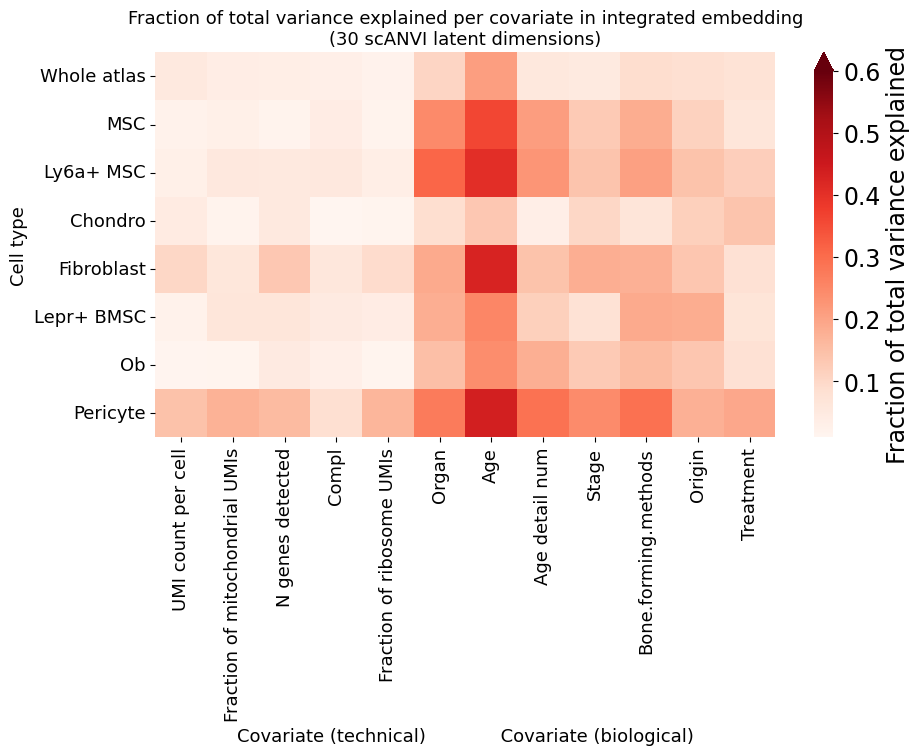

In [87]:
fz = 13  # fontsize
import copy
from matplotlib import cm
cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
fig, ax = plt.subplots(figsize=(10, 5))  # figsize
vmax = 0.6
title = "Fraction of total variance"
# for file storing:
title_no_spaces = title.replace(" ", "_")
sns.heatmap(
    vars_expl_to_plot.loc[cellTypeOrder,covOrder].astype(float),
    ax=ax,
    vmax=vmax,
    cbar_kws={"extend": "max"},
    mask=mask_overall.loc[vars_expl_to_plot.index, covOrder].values,
    cmap=cmap,
)
ax.collections[0].colorbar.set_label(f"{title} explained", fontsize=fz + 4)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fz)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fz)
plt.title(
    f"{title} explained per covariate in integrated embedding\n(30 scANVI latent dimensions)",
    fontsize=fz,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fz + 4)
plt.xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
plt.ylabel("Cell type", fontsize=fz)

plt.savefig("../result/10.24_covariance/C7_heatmap.pdf", bbox_inches="tight")
plt.show()
plt.close()
